# NETFLIX DATA ANALYSIS AND RECOMMENDATION SYSTEM

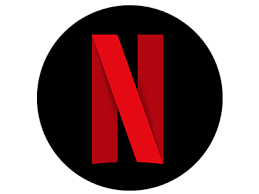

Netflix is the world's leading streaming entertainment service with 183 million paid memberships in over 190 countries enjoying TV series, documentaries and feature films across a wide variety of genres and languages. Members can watch as much as they want, anytime, anywhere, on any internet-connected screen. Members can play, pause and resume watching, all without commercials or commitments.

## Loading required libraries with installation.

In [75]:

import pandas as pd  # for dataframes
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt #for plotting graphs
import plotly.figure_factory as ff
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import missingno as msno
import squarify
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import altair as alt
import plotly.graph_objects as go




import warnings
warnings.filterwarnings("ignore")

In [76]:
print(f'numpy : {np.__version__}')
print(f'pandas : {pd.__version__}')
print(f'seaborn : {sns.__version__}')
print(f'matplotlib : {matplotlib.__version__}')
print(f'altair : {alt.__version__}')

numpy : 1.16.5
pandas : 0.25.1
seaborn : 0.9.0
matplotlib : 3.1.1
altair : 4.1.0


## Data Cleaning

In [77]:
netflix = pd.read_csv("F:\\Datasets\\netflix_titles.csv")
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [78]:
#Getting basic ideas about the data
print("dataset having {} rows and {} columns".format(netflix.shape[0], netflix.shape[1]))

dataset having 6234 rows and 12 columns


In [79]:
#Number of NULL values for the columns:
netflix.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

In [80]:
#finding how many percents null values are columns 
for i in netflix.columns:
    null_rate = netflix[i].isna().sum() / len(netflix) * 100 
    if null_rate > 0 :
        print(f"{i}'s null rate : {null_rate}%")

director's null rate : 31.584857234520374%
cast's null rate : 9.143407122232915%
country's null rate : 7.635547000320821%
date_added's null rate : 0.17645171639396856%
rating's null rate : 0.16041065126724416%


In [81]:
#Adding basic new features:
netflix['country'] = netflix['country'].fillna('No country')
netflix['date_added'] = netflix['date_added'].fillna('NULL')
netflix['year_added'] = netflix['date_added'].apply(lambda x :  x.split(',')[-1])
netflix['year_added'] = netflix['year_added'].apply(lambda x : x if x != 'NULL' else '2020')
netflix['year_added'] = netflix['year_added'].apply(int)
netflix['year_added'].unique()

array([2019, 2016, 2018, 2017, 2015, 2011, 2014, 2013, 2012, 2009, 2010,
       2020, 2008], dtype=int64)

In [82]:
#created Function to check the maturity according to ratings
def maturity_data(Rating):
    if Rating  == "G" or Rating  == "TV-Y" or Rating  == "TV-G" :
        return "Little Kids"
    elif Rating  == "G" or Rating  == "PG" or Rating  == "TV-Y7" or Rating  == "TV-Y7-FV" or Rating  == "TV-PG":
        return "Older Kids"
    elif Rating  == "PG-13" or Rating  == "TV-14":
        return "Teens"
    elif Rating  == "R" or Rating  == "NC-17" or Rating  == "TV-MA" :
        return "Mature"
    else:
        return "Not Rated"

In [83]:
#Here we are adding the new column 'maturity' 
netflix['maturity'] = netflix['rating'].apply(maturity_data)

In [84]:
#Here split the data into two database accordingly TV and movie 
movie = netflix[netflix['type'] == 'Movie']
tv_show = netflix[netflix['type'] == 'TV Show']

## Exploratory Data Analysis

#### Que: What kind of content does Netflix have the most?

In [85]:
values = netflix['type'].value_counts()
labels = values.index.tolist()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6, title = "Type Distribution")])

fig.show()

    Result - More than 50% content of netflix is Movies, rather than TV shows.

#### Que: Which words are the most prevelant in the netflix descriptions?

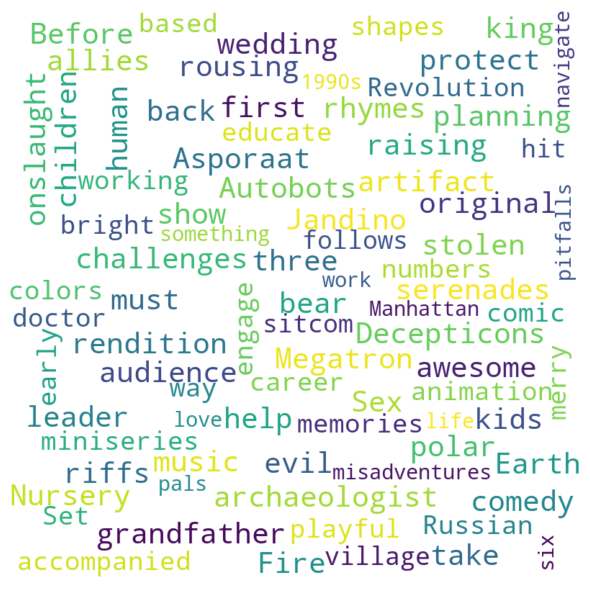

In [86]:
text = netflix['description'].values 
stopwords = set(STOPWORDS)

wc = WordCloud( background_color='white',
                          stopwords=stopwords,
                          width = 800, 
                          height = 800,
                          max_words=500,
                          max_font_size=40,
                          #min_font_size = 10,
                          random_state=42).generate(str(text))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()


    Mostly used keywords Wedding, Grandfather, Nursery, Kids are some of the most utilize keywords for the description. 

#### Que: List out the TOP-20 countries for netflix content production

In [87]:
new_netflix = pd.DataFrame(netflix.country.replace(' ,',',').replace(', ',',').str.split(',').tolist(),
                                index=netflix.year_added).stack()
new_netflix = new_netflix.reset_index([0, 'year_added'])
new_netflix.columns = ['year_added','country']
new_netflix = new_netflix[new_netflix.country != "No country"]
new_netflix

,year_added,country
0,2019,United States
1,2019,India
2,2019,South Korea
3,2019,China
4,2016,United Kingdom
...,...,...
7651,2020,Australia
7653,2020,United States
7654,2020,United States
7656,2020,United Kingdom


In [88]:
new_netflix['country'] = new_netflix['country'].str.strip()

In [89]:
from collections import Counter
country_data = new_netflix['country']
counting_countries = pd.Series(dict(Counter(country_data))).sort_values(ascending=False)
#counting_countries[counting_countries.ne('Null').all(1)]
top_20 = counting_countries.head(20)
top_20

United States     2610
India              838
United Kingdom     602
Canada             318
France             271
Japan              231
Spain              178
South Korea        162
Germany            151
Mexico             129
Australia          126
China              120
Hong Kong           97
Turkey              87
Taiwan              75
Argentina           68
Italy               67
Brazil              66
Belgium             66
Thailand            56
dtype: int64

In [90]:

tot = sum(counting_countries)
top20 = sum(counting_countries[:20]) # 22 is real 20% but for simple processing

print(f'total : {tot}')
print(f'top 20 countries : {top20}')
print(f'percentage : {top20}/{tot} = {100 * top20/tot}')


total : 7182
top 20 countries : 6318
percentage : 6318/7182 = 87.96992481203007


In [91]:
top20_country = counting_countries[:20]

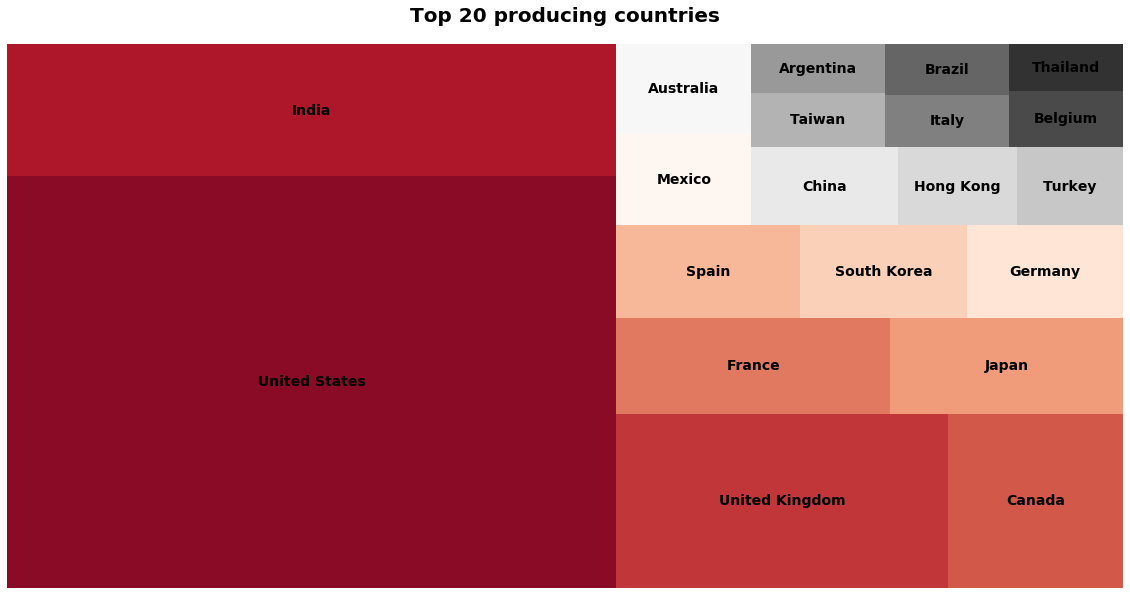

In [92]:

y = top_20
fig = plt.figure(figsize=(20,10))
squarify.plot(sizes = y.values, label = y.index, color = sns.color_palette("RdGy", n_colors=20),
             linewidth=4, text_kwargs={'fontsize':14, 'fontweight' : 'bold'})
plt.title('Top 20 producing countries', position=(0.5, 1.0+0.03), fontsize = 20, fontweight='bold')
plt.axis('off')
plt.show()


    United States, India and United Kingdom are the top-3 countiries for content production.

#### Que: Compare the Netflix content production with year (2008 to 2020)

In [93]:

import plotly.express as px
year_country = new_netflix.groupby('year_added')['country'].value_counts().reset_index(name='counts')

fig = px.choropleth(year_country, locations="country", color="counts", 
                    locationmode='country names',
                    animation_frame='year_added',
                    range_color=[0,200],
                    color_continuous_scale=px.colors.sequential.OrRd,
                    title='Comparison by country'
                   )

fig.show()



    From the beginning, USA is most content producing country.

#### Que: Check the correlation between the genres

In [94]:
#creating heatmap
def create_heatmap(df, title):
    
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    num = []
    for i in df['genre']: num += i
    num = set(num)
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corrMatrix = res.corr()
    mask = np.zeros_like(corrMatrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(13, 11))
    ax=sns.heatmap(corrMatrix,vmin=-.5, vmax=.5, center=0, mask=mask,
                    cmap="YlGnBu",
                    square=True,linewidths=.7,
                    cbar_kws={"shrink": 0.6})
    ax.set_xticklabels(ax.get_xticklabels(),
                        rotation=40,
                        horizontalalignment='right'
                                                    );
    ax.set_title(f"Correlations between {len(num)} types of genres ")

    plt.show()
    


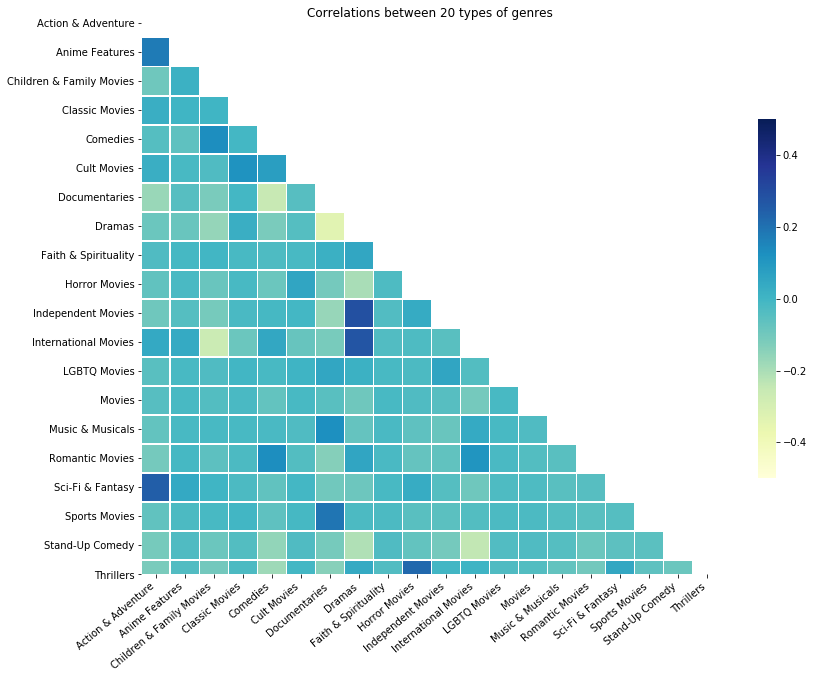

In [95]:
create_heatmap(movie,'Movie')

    In movies, Documentaries and Dramas having highest negative relationship. In oppose, Drama having posotive relation with Independent movies nad International movies.

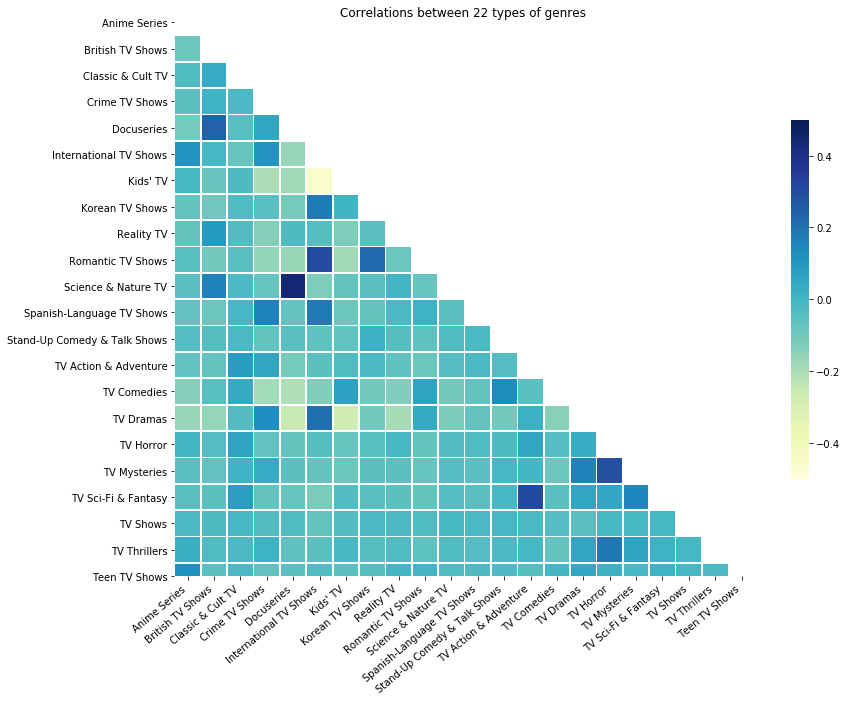

In [96]:
create_heatmap(tv_show,'TV Show')

    In case of Tv shows, Kids and International are negetive realtion genres.

### Ratings Analysis

The Motion Picture Association (MPA) film rating system is used in the United States and its territories to rate a film's suitability for certain audiences based on its content. 

    According to the MPA, 
                G , TV-Y , TV-G               => "LITTLE KIDS"
                PG , TV-Y7 , TV-Y7-FV , TV-PG => "OLDER KIDS"
                PG-13 , TV-14                 => "TEENS"
                R , NC-17 , TV-MA             =>"MATURE"
                NR , UR                       => "NOT RATED" 

In [97]:
unique_ratings = netflix['rating'].unique()

In [98]:
rating_list =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA', 'NR', 'UR']
netflix_ratings = netflix[['rating', 'type']].groupby('type')['rating'].value_counts().unstack().fillna(0)[rating_list].T
netflix_ratings = pd.DataFrame(pd.concat([netflix_ratings['Movie'], netflix_ratings['TV Show']])).reset_index().rename(columns={'rating':'rating',0:'cnt'})
netflix_ratings['type'] = netflix_ratings.index//12
#movie__ratings = netflix_ratings[netflix_ratings['type'] == 'Movie']
#tv_ratings = netflix_ratings[netflix_ratings['type'] == '1']
netflix_ratings

,rating,cnt,type
0,G,36.0,0
1,TV-Y,41.0,0
2,TV-G,80.0,0
3,PG,183.0,0
4,TV-Y7,69.0,0
5,TV-Y7-FV,27.0,0
6,TV-PG,432.0,0
7,PG-13,286.0,0
8,TV-14,1038.0,0
9,R,506.0,0


#### Que: How many percent of netflix content is Not Rated.

In [99]:
overall_rat = netflix_ratings
overall_rat = overall_rat.drop(labels = 'type', axis=1)
overall_rat = overall_rat.replace("UR" , "NR")
overall_rat['rating'] = np.where(overall_rat['rating'] != 'NR', "Rated","Not Rated")
overall_rat = overall_rat.groupby(['rating'] , as_index=False)['cnt'].sum()
overall_rat

,rating,cnt
0,Not Rated,225.0
1,Rated,5999.0


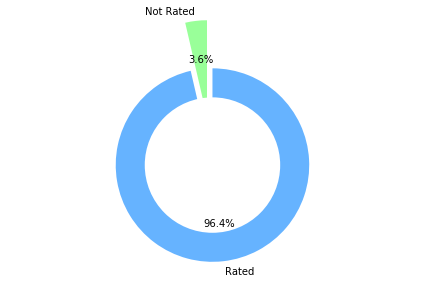

In [100]:
import matplotlib.pyplot as plt

#colors
colors = ['#99ff99','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(overall_rat['cnt'], colors = colors, labels=overall_rat['rating'], autopct='%1.1f%%', startangle=90, explode = (0.5,0))
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

#### Que: Which kind of content netflix uploads more for Teenages ? 

In [101]:
rating_order = ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']
base = alt.Chart(netflix_ratings).transform_calculate(
    type=alt.expr.if_(alt.datum.type == 0, 'Movie', 'TV Show')
    ).properties(
        height=400,
        width=300
    )

colors = alt.Scale(domain = ['Movie','TV Show'], range=['#5bc0de', '#d9534f'])

left = base.transform_filter(
        alt.datum.type == 'Movie'
                ).transform_joinaggregate(
                    TotalTime='sum(cnt)',
                ).transform_calculate(
                PercentOfTotal="datum.cnt / datum.TotalTime"
                ).encode(
                    y=alt.Y('rating:O', axis=None, sort=rating_order),
                    x=alt.X('PercentOfTotal:Q', axis=None, sort=alt.SortOrder('descending')),
                    color=alt.Color('type:N', scale=colors, legend=None)
                ).mark_bar().properties(title='Movie')
middle = base.encode(
    y=alt.Y('rating', axis=None, sort=rating_order),
    text=alt.Text('rating'),
    ).mark_text().properties(title = 'Ratings', width=30)

right = base.transform_filter(
        alt.datum.type == 'TV Show'
                ).transform_joinaggregate(
                    TotalTime='sum(cnt)',
                ).transform_calculate(
                PercentOfTotal="datum.cnt / datum.TotalTime"
                ).mark_text(
                        align='left',
                        baseline='middle',
                        fontSize = 20,
                        dx = 7
                ).encode(
                    y=alt.Y('rating:O', axis=None, sort=rating_order),
                    x=alt.X('PercentOfTotal:Q', axis=None),
                    text=alt.Text('PercentOfTotal:Q', format='%4.1f'),
                    color=alt.Color('type:N', scale=colors, legend=None)
                ).mark_bar().properties(title='TV Show')

alt.concat(left, middle, right, spacing=5).configure_axis(grid=False).configure_view(stroke=None)



alt.ConcatChart(...)

    Netflix uploads more TV Show content in compare of Movies for Teenagers.

### Content based Recommendation System

They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it

In [102]:
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix['description'] = netflix['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(6234, 16151)

#### Cosine Similarity

Cosine similarity is the measure of similarity between two vectors, by computing the cosine of the angle between two vectors projected into multidimensional space. It can be applied to items available on a dataset to compute similarity to one another via keywords or other metrics

In [103]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [104]:
#filling null values with empty str
filledna = netflix.fillna('')


In [105]:
def cleaning(x):
    return str.lower(x.replace(" ", ""))

Here in this recommendation system I will focuse on movies & Tv shoews title, director, cast, geners, content description.

In [106]:
features = ['title', 'director', 'cast', 'listed_in', 'description']
filledna = filledna[features]
filledna

,title,director,cast,listed_in,description
0,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,Jandino: Whatever it Takes,,Jandino Asporaat,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,Transformers Prime,,"Peter Cullen, Sumalee Montano, Frank Welker, J...",Kids' TV,"With the help of three human allies, the Autob..."
3,Transformers: Robots in Disguise,,"Will Friedle, Darren Criss, Constance Zimmer, ...",Kids' TV,When a prison ship crash unleashes hundreds of...
4,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...
6229,Red vs. Blue,,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...","TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,Maron,,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,Little Baby Bum: Nursery Rhyme Friends,,,Movies,Nursery rhymes and original music for children...
6232,A Young Doctor's Notebook and Other Stories,,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...","British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [107]:
for feature in features:
    filledna[feature] = filledna[feature].apply(cleaning)
    
filledna.head()

,title,director,cast,listed_in,description
0,normofthenorth:kingsizedadventure,"richardfinn,timmaltby","alanmarriott,andrewtoth,briandobson,colehoward...","children&familymovies,comedies",beforeplanninganawesomeweddingforhisgrandfathe...
1,jandino:whateverittakes,,jandinoasporaat,stand-upcomedy,jandinoasporaatriffsonthechallengesofraisingki...
2,transformersprime,,"petercullen,sumaleemontano,frankwelker,jeffrey...",kids'tv,"withthehelpofthreehumanallies,theautobotsoncea..."
3,transformers:robotsindisguise,,"willfriedle,darrencriss,constancezimmer,kharyp...",kids'tv,whenaprisonshipcrashunleasheshundredsofdecepti...
4,#realityhigh,fernandolebrija,"nestacooper,katewalsh,johnmichaelhiggins,keith...",comedies,whennerdyhighschoolerdanifinallyattractstheint...


In [108]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [109]:
filledna['soup'] = filledna.apply(create_soup, axis=1)

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(filledna['soup'])

cos_sim = cosine_similarity(count_matrix, count_matrix)


In [111]:
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])


In [112]:
def get_recommendations(title, cosine_sim=cosine_sim):   
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix['title'].iloc[movie_indices]

 varification of recommendations system

In [113]:
get_recommendations('You', cos_sim)

5615     Beauty & the Beast
1652       Sotus The Series
3817               Unsolved
5923    Pyaar Tune Kya Kiya
560           Here to Heart
955                  Sudden
4440      Twice Upon A Time
6114                 Wanted
1459             Get Shorty
1643        Kiss The Series
Name: title, dtype: object

In [114]:
get_recommendations('13 Reasons Why', cos_sim)

6152    13 Reasons Why: Beyond the Reasons
6164                            MINDHUNTER
6175                            The Sinner
61                               Frequency
1705                           The Keepers
2437                         The Staircase
5879                        Criminal Minds
1109                            Dirty John
5842           How to Get Away with Murder
2487                     Somewhere Between
Name: title, dtype: object

In [115]:
get_recommendations('Blue Exorcist', cos_sim)

3839                                Attack on Titan
4414                                     Durarara!!
4649                                   Black Butler
4708                                              K
2989                      Magi: Adventure of Sinbad
3356                                       Godzilla
2953                                      God Eater
4289    The Disastrous Life of Saiki K.: Reawakened
5685                          The Seven Deadly Sins
3182                      GODZILLA The Planet Eater
Name: title, dtype: object

In [116]:
get_recommendations('American Horror Story', cos_sim)

2333                                Darr Sabko Lagta Hai
5690                                             Haunted
2734                       Fear Files... Har Mod Pe Darr
4511                                 Anjaan: Rural Myths
552                                             The Mist
3929                                                Milk
5794                                           Bloodline
1838                         Anjaan: Special Crimes Unit
5845                                  Santa Clarita Diet
1966    American Crime Story: The People v. O.J. Simpson
Name: title, dtype: object

Here, we have selected the "American Horror Story", which is Tv show. Almost, all recommendations content genre are similar to 
the selected content. Majority of recommendation is Tv Shows. 